## Loading the small datasets

In [4]:
#Add the current path into the system path
import sys,os
curPath = os.path.abspath(os.path.dirname("/home/murrawang/"))
sys.path.append(curPath)

# Import necessary libraries
from pyspark.sql import SQLContext
import graphframes
from graphframes import *
from AggregateMessages import *

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import col, lit, when, avg, collect_list, mean, row_number
from pyspark.sql import Row
from pyspark.sql.window import Window

from datetime import datetime
import numpy as np

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [5]:
#loading the target dataset
review_path = "hdfs:///yelp/yelp_review.json"
yelp_review = spark.read.json(review_path)

In [6]:
# ALS algorithm needs IDs to be numerical type, so I transfer the string type ID to the numerical type ID.
w = Window().orderBy(lit('A'))
yelp_user_with_numid = yelp_review.select("user_id").distinct().withColumn("user_numid", row_number().over(w))
yelp_business_with_numid = yelp_review.select("business_id").distinct().withColumn("business_numid", row_number().over(w))
yelp_review = yelp_review.join(yelp_user_with_numid, "user_id", "left").join(yelp_business_with_numid, "business_id", "left")

## Define functions for calculating the RMSE of both methods

In [7]:
# Calculating the recommendation power
def RecommendPower(row):
    rp = (row.b1_stars*row.b2_stars)/(row.b1_total_bstars*float(row.user_info[1]))
    return Row(b1_id=row.b1_id, b2_id=row.b2_id, rp=rp)

# predict the ratings
def Prediction(row):
    pred = row.avg_stars
    if (row.sim_list is not None and row.br_list is not None):
        for i in range(len(row.sim_list)):
            for j in range(len(row.br_list)):
                if row.sim_list[i][0] == row.br_list[j][0]:
                    pred += float(row.sim_list[i][2])*(float(row.br_list[j][1])-float(row.sim_list[i][1]))
    return Row(business_id=row.business_id, user_id=row.user_id, actual_stars=row.stars, pred_stars=pred)

# Calculate the rmse of WBGP approach
def WBGPrmse(training_r, test_r):
    yelp_user = yelp_review.select("user_id").distinct()
    yelp_user = yelp_user.join(training_r.groupBy("user_id").avg("stars").withColumnRenamed("avg(stars)", "avg_stars"), "user_id", "left").\
                  join(training_r.groupBy("user_id").count().withColumnRenamed("count", "review_count"), "user_id", "left").na.fill(0)
    yelp_business = yelp_review.select("business_id").distinct()
    yelp_business = yelp_business.join(training_r.groupBy("business_id").avg("stars").withColumnRenamed("avg(stars)", "avg_stars"), "business_id", "left").\
                  join(training_r.groupBy("business_id").count().withColumnRenamed("count", "review_count"), "business_id", "left").na.fill(0)
    bt = yelp_business.rdd.map(lambda r: Row(business_id=r.business_id, total_bstars=r.avg_stars*r.review_count)).toDF()
    ut = yelp_user.rdd.map(lambda r: Row(user_id=r.user_id, total_ustars=r.avg_stars*r.review_count)).toDF()
    review_with_info = training_r.join(ut, "user_id", "left").join(bt, "business_id", "left")\
                               .rdd.map(lambda r: Row(user_info=["U"+str(r.user_id), r.total_ustars], business_id="B"+str(r.business_id), total_bstars=r.total_bstars, \
                                stars=r.stars)).toDF()
    df_as1 = review_with_info.withColumnRenamed("business_id", "b1_id").\
               withColumnRenamed("stars", "b1_stars").withColumnRenamed("total_bstars", "b1_total_bstars")
    df_as2 = review_with_info.withColumnRenamed("business_id", "b2_id").\
               withColumnRenamed("stars", "b2_stars").withColumnRenamed("total_bstars", "b2_total_bstars")
    bpairs = df_as1.join(df_as2, "user_info")
    bpairs_withrp = bpairs.rdd.map(RecommendPower).toDF()
    business_similarity = bpairs_withrp.groupBy(["b1_id", "b2_id"]).sum("rp").withColumnRenamed("sum(rp)", "similarity")
    
    businessVertices = yelp_business.rdd.map(lambda r: Row(id="B"+str(r.business_id), vtype="business", avg_stars=r.avg_stars, review_count=r.review_count)).toDF()
    userVertices = yelp_user.rdd.map(lambda r: Row(id="U"+str(r.user_id), vtype="user", avg_stars=r.avg_stars, review_count=r.review_count)).toDF()
    reviewEdges = training_r.join(yelp_user, "user_id", "left")\
                      .rdd.map(lambda r: Row(src="U"+str(r.user_id),dst="B"+str(r.business_id), \
                       ustars=["U"+str(r.user_id), r.avg_stars*r.review_count, r.stars], \
                        bstars=["B"+str(r.business_id), r.stars])).toDF()
    bipartiteVertices = userVertices.unionAll(businessVertices)
    bipartiteGraph = GraphFrame(bipartiteVertices, reviewEdges)
    business_similarity = business_similarity.join(businessVertices.select("id", "avg_stars").\
                         withColumnRenamed("id", "b2_id").withColumnRenamed("avg_stars", "b2_avg_stars"), "b2_id", "left")
    weightEdges = business_similarity.rdd.map(lambda r: Row(src=r.b1_id, dst=r.b2_id, sim=[r.b2_id, r.b2_avg_stars, r.similarity])).toDF()
    BGprojection = GraphFrame(businessVertices, weightEdges)
    testr_withprefix = test_r.rdd.map(lambda r: Row(business_id="B"+str(r.business_id), user_id="U"+str(r.user_id), stars=r.stars)).toDF()
    msgtoSrc = AM.edge['sim']
    testr_withsim = BGprojection.aggregateMessages\
                            (collect_list(AM.msg).alias('sim_list'), sendToSrc=msgtoSrc).withColumnRenamed("id", "business_id").\
                            join(testr_withprefix, "business_id", "right").\
                            join(businessVertices.select("id", "avg_stars").withColumnRenamed("id", "business_id"), "business_id", "left")
    msgtoSrc = AM.edge['bstars']
    testr_withsimbr = bipartiteGraph.aggregateMessages\
                            (collect_list(AM.msg).alias('br_list'), sendToSrc=msgtoSrc).withColumnRenamed("id", "user_id").\
                            join(testr_withsim, "user_id", "right")
    result = testr_withsimbr.rdd.map(Prediction).toDF()
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="actual_stars", predictionCol="pred_stars")
    rmse = evaluator.evaluate(result)
    return rmse

# Calculate the rmse of ALS approach
def ALSrmse(training_r, test_r):
    numberLatentFactors = 3
    als = ALS(rank=numberLatentFactors, maxIter=14, regParam=0.5, 
          userCol="user_numid", itemCol="business_numid", ratingCol="stars", 
          coldStartStrategy="drop")
    model = als.fit(training_r)
    predictions = model.transform(test_r)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    return rmse



## Compare the results

In [ ]:
# I calculate the test rmse of both methods for 5 runs.
rmseforWBGP = []
rmseforALS = []
runs = 5
for i in range(runs):
    # split the review data to training and test parts
    (training, test) = yelp_review.randomSplit([0.8, 0.2], seed=i+8)
    training.cache()
    test.cache()
    rmseforWBGP.append(WBGPrmse(training, test))
    rmseforALS.append(ALSrmse(training, test))

In [11]:
# Summary of the result
print("RMSE for WBGP: ", rmseforWBGP)
print("RMSE for ALS: ", rmseforALS)
print("Average RMSE for WBGP:", np.mean(rmseforWBGP))
print("Average RMSE for ALS:", np.mean(rmseforALS))
print("Standard Error of RMSE for WBGP:", np.std(rmseforWBGP))
print("Standard Error of RMSE for ALS:", np.std(rmseforALS))

('RMSE for WBGP: ', [1.41265912825269, 1.4030538911480255, 1.399520900504731, 1.4010496727075687, 1.3998860584731567])
('RMSE for ALS: ', [2.249842108546035, 2.2611314369532822, 2.2892678320042106, 2.2440321396321545, 2.2366928261125545])
('Average RMSE for WBGP:', 1.4032339302172345)
('Average RMSE for ALS:', 2.256193268649647)
('Standard Error of RMSE for WBGP:', 0.0048709873291408355)
('Standard Error of RMSE for ALS:', 0.018367415714108097)


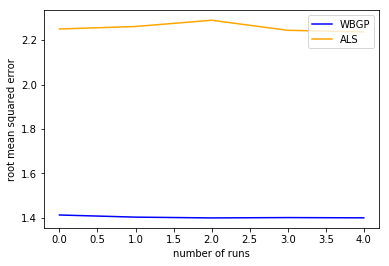

In [12]:
#### plotting ####
plt.plot(rmseforWBGP, color='blue', label='WBGP')
plt.plot(rmseforALS, color='orange', label='ALS')
plt.legend(loc='upper right')
plt.xlabel('number of runs')
plt.ylabel('root mean squared error')
plt.show()